## Imorting Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
custom_palette = sns.color_palette("coolwarm", n_colors=10)
sns.set_palette(custom_palette)

c:\Users\abdul\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Exploration

In [3]:
data = pd.read_csv("retail_store_inventory.csv")

In [4]:
data.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [6]:
data.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [7]:
data.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

### Initial Data Preprocessing

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
data.set_index('Date', inplace=True)

In [10]:
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [11]:
scaler = MinMaxScaler()
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

## Exploratory Data Analysis

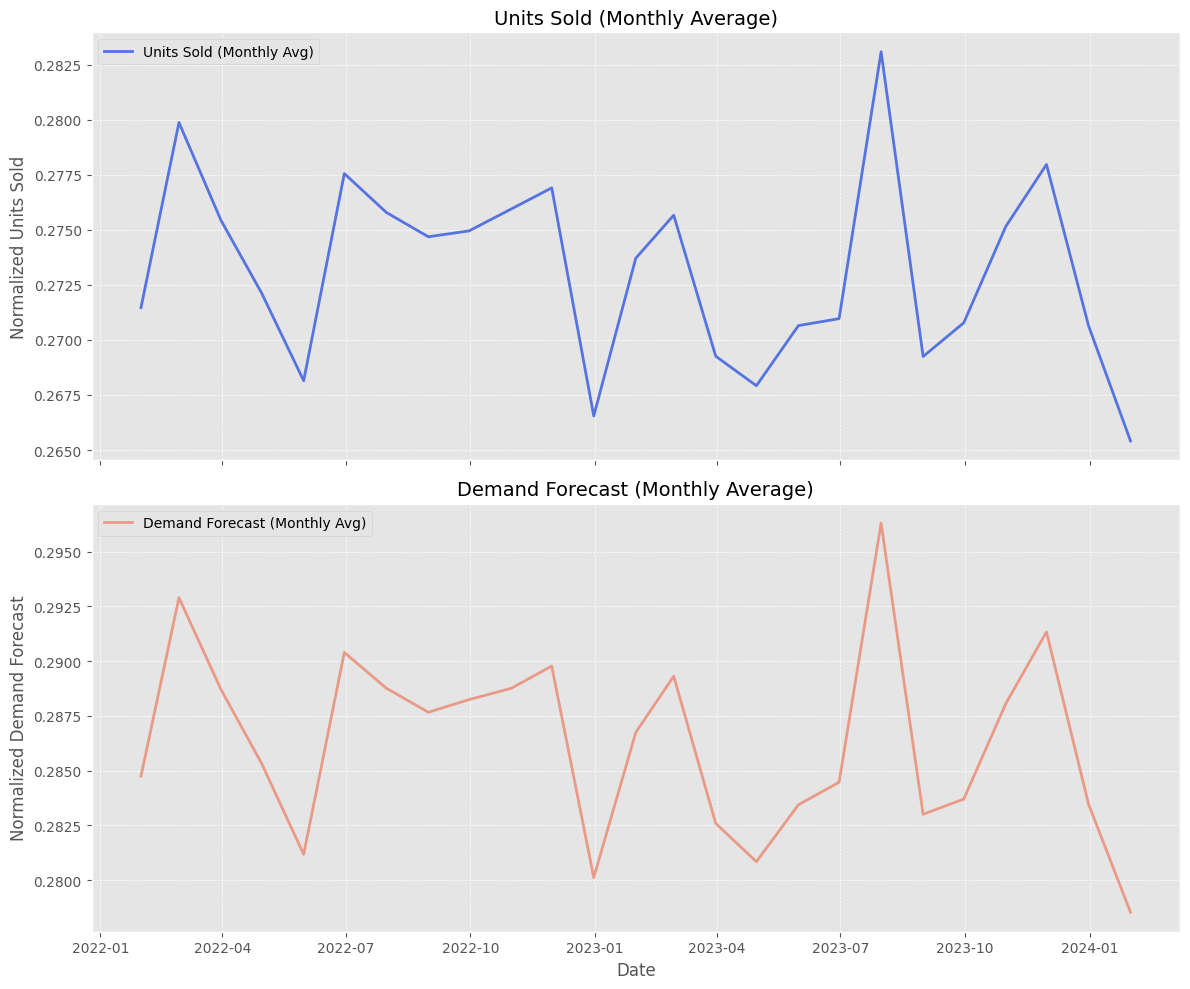

In [12]:
monthly_data = data.resample('M').mean()
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(monthly_data.index, monthly_data['Units Sold'], label='Units Sold (Monthly Avg)', color=custom_palette[0], linewidth=2)
axes[0].set_title('Units Sold (Monthly Average)', fontsize=14)
axes[0].set_ylabel('Normalized Units Sold', fontsize=12)
axes[0].legend(fontsize=10, loc='upper left')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

axes[1].plot(monthly_data.index, monthly_data['Demand Forecast'], label='Demand Forecast (Monthly Avg)', color=custom_palette[8], alpha=0.7, linewidth=2)
axes[1].set_title('Demand Forecast (Monthly Average)', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Normalized Demand Forecast', fontsize=12)
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

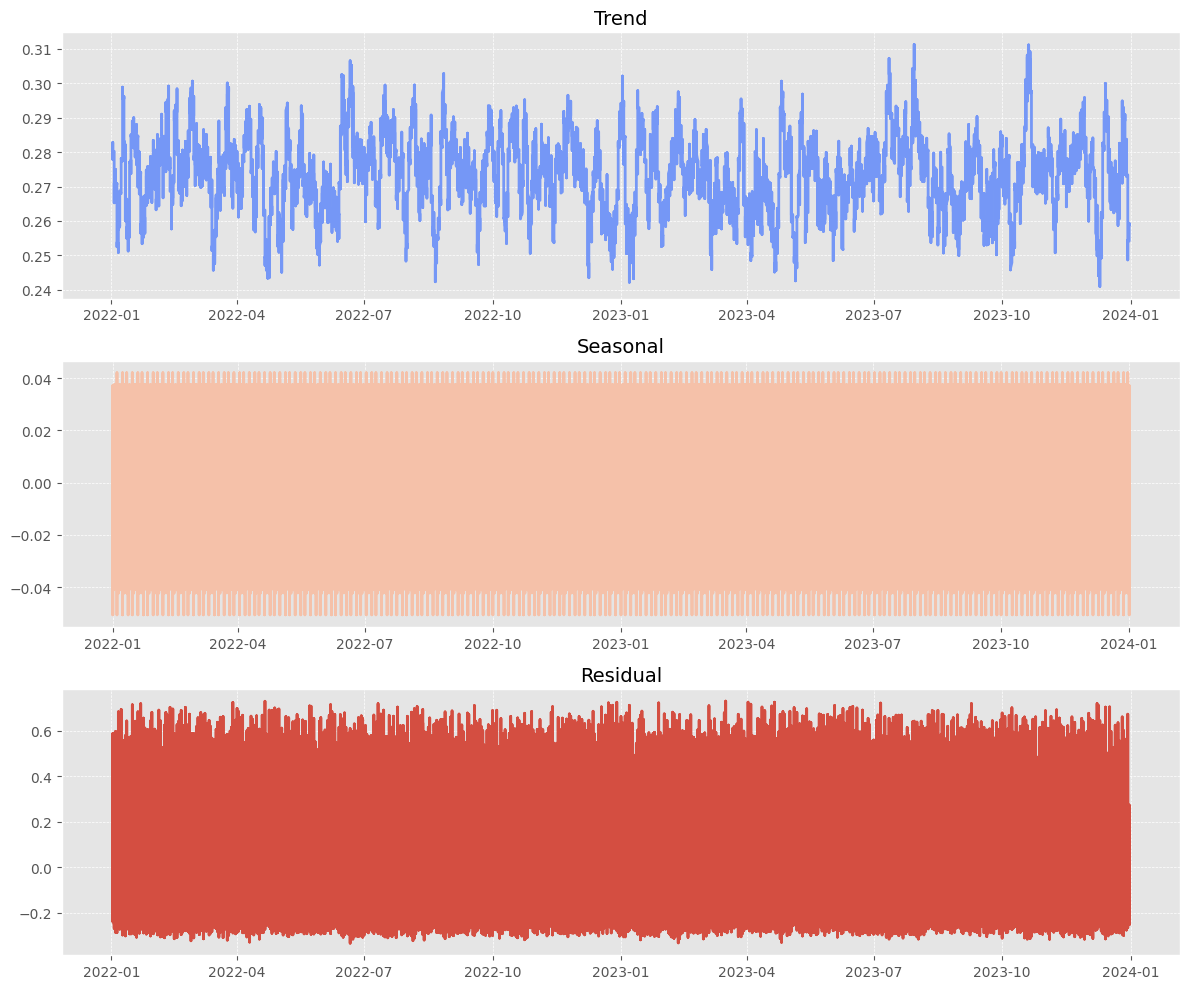

In [13]:
result = seasonal_decompose(data['Units Sold'], model='additive', period=365)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(result.trend, color=custom_palette[1], linewidth=2)
axes[0].set_title('Trend', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)

axes[1].plot(result.seasonal, color=custom_palette[6], linewidth=2)
axes[1].set_title('Seasonal', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)

axes[2].plot(result.resid, color=custom_palette[9], linewidth=2)
axes[2].set_title('Residual', fontsize=14)
axes[2].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

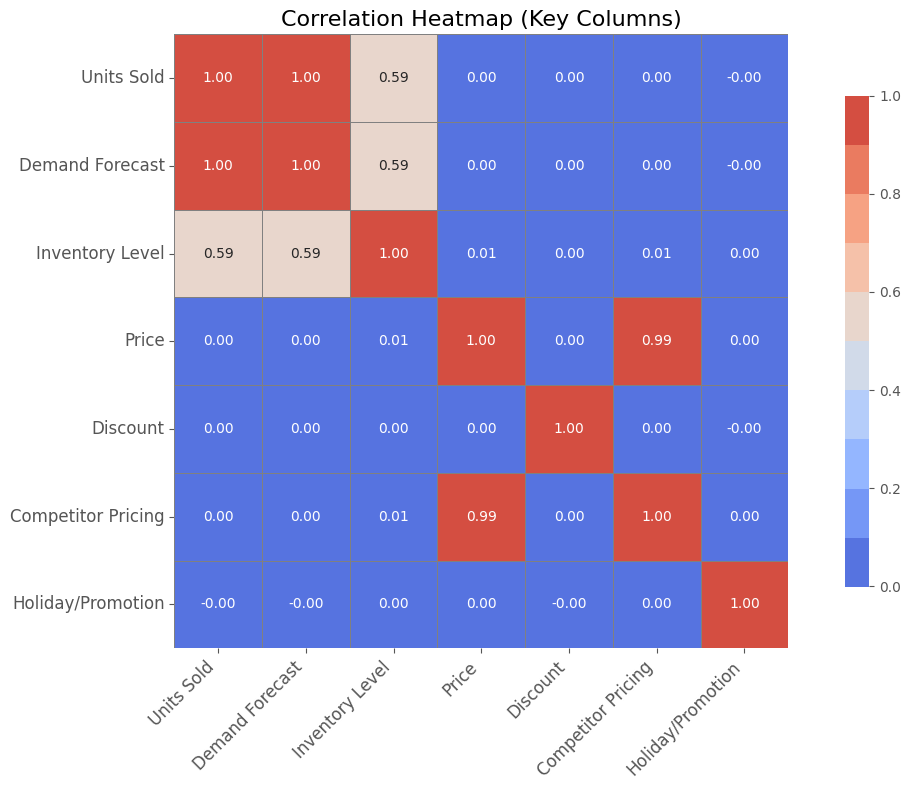

In [14]:
key_columns = ['Units Sold', 'Demand Forecast', 'Inventory Level', 'Price', 'Discount', 'Competitor Pricing', 'Holiday/Promotion']
plt.figure(figsize=(12, 8))
sns.heatmap(data[key_columns].corr(), annot=True, cmap=custom_palette, fmt='.2f', cbar_kws={'shrink': 0.8}, linewidths=0.5, linecolor='gray', square=True)
plt.title('Correlation Heatmap (Key Columns)', fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

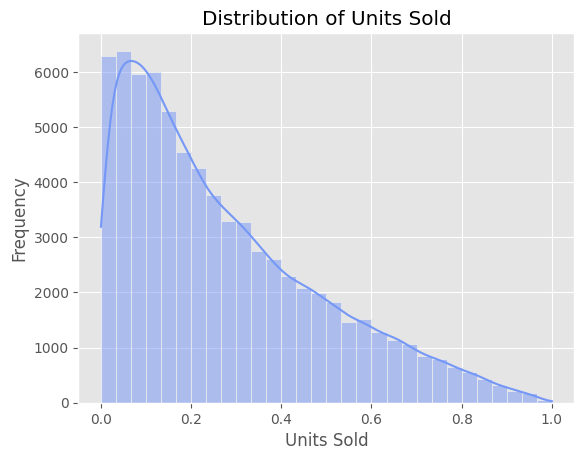

In [15]:
sns.histplot(data['Units Sold'], kde=True, bins=30, color=custom_palette[1])
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

### Outlier Analysis

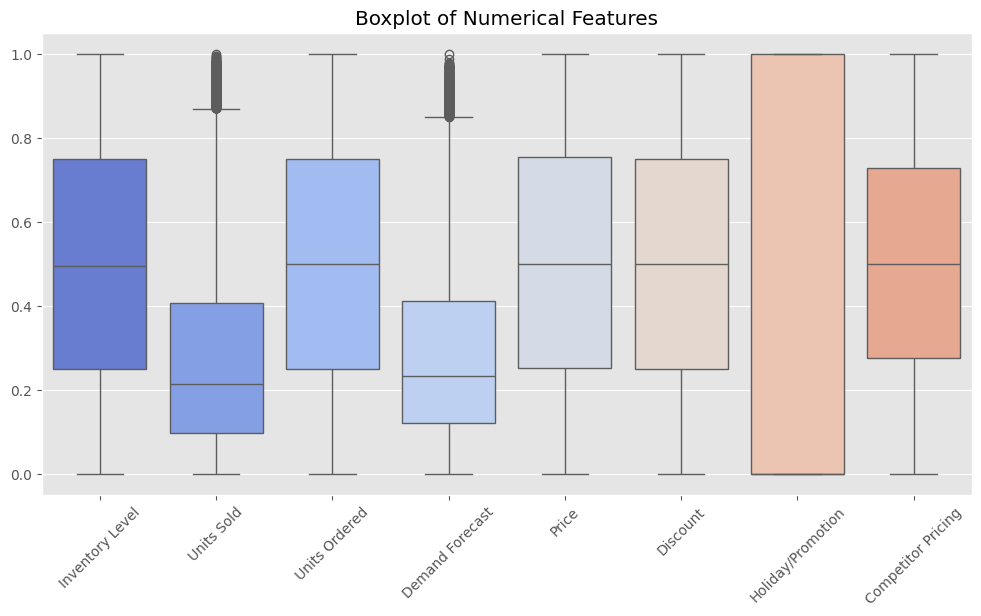

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numerical_cols], palette=custom_palette)
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

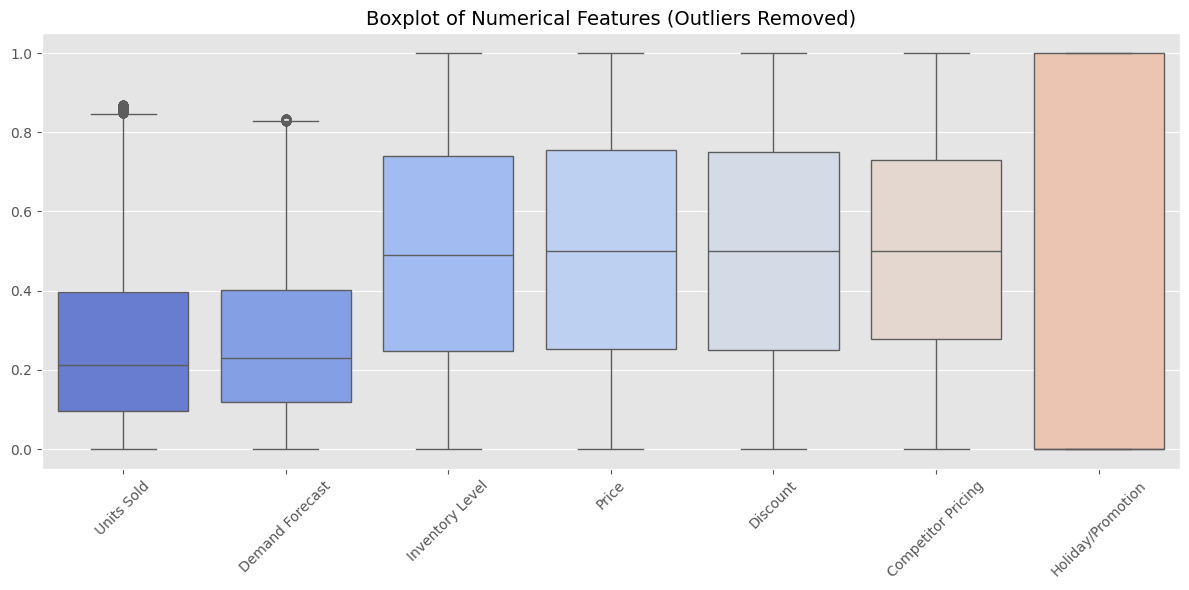

In [17]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

data = remove_outliers(data, key_columns)

plt.figure(figsize=(12, 6))
sns.boxplot(data=data[key_columns], palette=custom_palette)
plt.title('Boxplot of Numerical Features (Outliers Removed)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Time Series Analysis

In [18]:
data['Units Sold Differenced'] = data['Units Sold'] - data['Units Sold'].shift(1)
data_differenced = data['Units Sold Differenced'].dropna()

adf_result_diff = adfuller(data_differenced)
print("\nADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])
print("Critical Values (Differenced):")
for key, value in adf_result_diff[4].items():
    print(f"\t{key}: {value}")


ADF Statistic (Differenced): -58.16775386827406
p-value (Differenced): 0.0
Critical Values (Differenced):
	1%: -3.4304407272978072
	5%: -2.8615800998730396
	10%: -2.5667913437890526


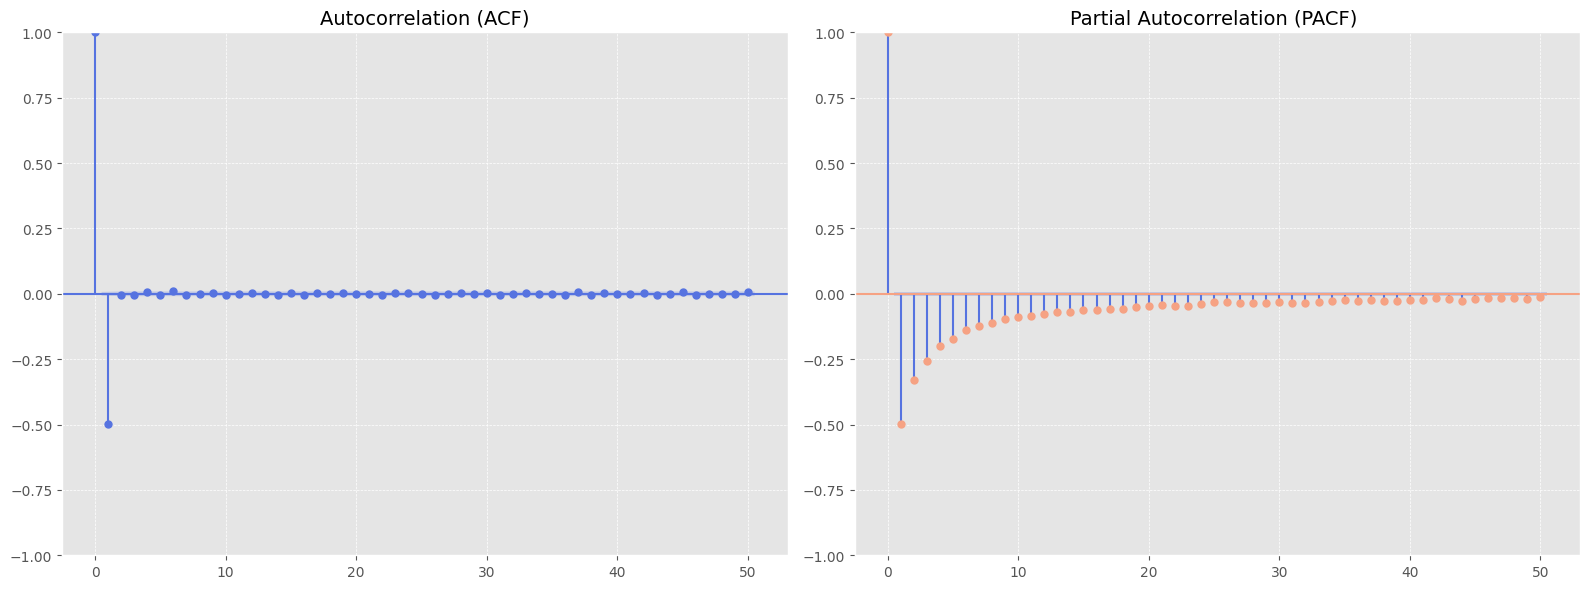

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data_differenced, ax=axes[0], lags=50, color=custom_palette[0])
axes[0].set_title('Autocorrelation (ACF)', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)

plot_pacf(data_differenced, ax=axes[1], lags=50, color=custom_palette[7])
axes[1].set_title('Partial Autocorrelation (PACF) ', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Feature Engineering

In [20]:
data['Month'] = data.index.month
data['Day'] = data.index.day
data['Week'] = data.index.isocalendar().week
data['Year'] = data.index.year

In [21]:
data['Lag_1'] = data['Units Sold'].shift(1)
data['Lag_7'] = data['Units Sold'].shift(7)
data['Lag_30'] = data['Units Sold'].shift(30)

In [22]:
data['Rolling_Mean_7'] = data['Units Sold'].rolling(window=7).mean()
data['Rolling_Std_7'] = data['Units Sold'].rolling(window=7).std()
data['Rolling_Mean_30'] = data['Units Sold'].rolling(window=30).mean()
data['Rolling_Std_30'] = data['Units Sold'].rolling(window=30).std()

In [24]:
data.columns

Index(['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing',
       'Store ID_S002', 'Store ID_S003', 'Store ID_S004', 'Store ID_S005',
       'Product ID_P0002', 'Product ID_P0003', 'Product ID_P0004',
       'Product ID_P0005', 'Product ID_P0006', 'Product ID_P0007',
       'Product ID_P0008', 'Product ID_P0009', 'Product ID_P0010',
       'Product ID_P0011', 'Product ID_P0012', 'Product ID_P0013',
       'Product ID_P0014', 'Product ID_P0015', 'Product ID_P0016',
       'Product ID_P0017', 'Product ID_P0018', 'Product ID_P0019',
       'Product ID_P0020', 'Category_Electronics', 'Category_Furniture',
       'Category_Groceries', 'Category_Toys', 'Region_North', 'Region_South',
       'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter', 'Units Sold Differenced', 'Month', 'Day', 

In [25]:
data = data.dropna()

In [26]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [27]:
train = train[~train.index.duplicated(keep='first')]
test = test[~test.index.duplicated(keep='first')]
train = train.asfreq('D')  
test = test.asfreq('D')

def fill_missing(series):
    return series.fillna(method='ffill').fillna(method='bfill')

train['Units Sold'] = fill_missing(train['Units Sold'])
test['Units Sold'] = fill_missing(test['Units Sold'])

In [28]:
train_rf_xgb = train.drop(columns=['Units Sold']).copy()
test_rf_xgb = test.drop(columns=['Units Sold']).copy()
categorical_cols = train_rf_xgb.select_dtypes(include=['category', 'object']).columns

if 'Week' in train_rf_xgb.columns:
    train_rf_xgb['Week'] = pd.factorize(train_rf_xgb['Week'])[0]
    test_rf_xgb['Week'] = pd.factorize(test_rf_xgb['Week'])[0]

if not categorical_cols.empty:
    train_rf_xgb = pd.get_dummies(train_rf_xgb, columns=categorical_cols)
    test_rf_xgb = pd.get_dummies(test_rf_xgb, columns=categorical_cols)

train_rf_xgb, test_rf_xgb = train_rf_xgb.align(test_rf_xgb, join='left', axis=1)
test_rf_xgb = test_rf_xgb.fillna(0)

In [29]:
results = {}

## Model Training

### Random Forest Regressor

In [30]:
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
best_rf_score = float("inf")
best_rf_params = None
for params in ParameterGrid(rf_param_grid):
    print(f"Training Random Forest with params: {params}")
    rf_model = RandomForestRegressor(**params, random_state=42)
    rf_model.fit(train_rf_xgb, train['Units Sold'])
    rf_predictions = rf_model.predict(test_rf_xgb)
    rf_score = mean_absolute_error(test['Units Sold'], rf_predictions)

    if rf_score < best_rf_score:
        best_rf_score = rf_score
        best_rf_params = params

print(f"Random Forest Best Params: {best_rf_params}, MAE: {best_rf_score}")
results['Random Forest'] = {"Best Params": best_rf_params, "MAE": best_rf_score}

Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training 

### XGBoost Model

In [31]:
xgb_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "tree_method": ["hist"]  # Specify tree_method explicitly
}
best_xgb_score = float("inf")
best_xgb_params = None
for params in ParameterGrid(xgb_param_grid):
    print(f"Training XGBoost with params: {params}")
    xgb_model = XGBRegressor(**params, random_state=42, enable_categorical=True)
    xgb_model.fit(train_rf_xgb, train['Units Sold'])
    xgb_predictions = xgb_model.predict(test_rf_xgb)
    xgb_score = mean_absolute_error(test['Units Sold'], xgb_predictions)

    if xgb_score < best_xgb_score:
        best_xgb_score = xgb_score
        best_xgb_params = params

print(f"XGBoost Best Params: {best_xgb_params}, MAE: {best_xgb_score}")
results['XGBoost'] = {"Best Params": best_xgb_params, "MAE": best_xgb_score}

Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'lea

### Prophet Model

In [32]:
prophet_train = train.reset_index().rename(columns={train.index.name: "ds", "Units Sold": "y"})
prophet_test = test.reset_index().rename(columns={test.index.name: "ds", "Units Sold": "y"})

prophet_model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

prophet_model.add_seasonality(name="quarterly", period=90, fourier_order=5)

prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

prophet_score = mean_absolute_error(prophet_test["y"].values, forecast["yhat"][:len(test)])
print(f"Prophet MAE: {prophet_score}")
results['Prophet'] = {"MAE": prophet_score}

08:32:48 - cmdstanpy - INFO - Chain [1] start processing
08:32:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 0.1859656143924527


## Best Model Selection

In [33]:
results_df = pd.DataFrame(results).T
print(results_df)

results_df = results_df.sort_values(by="MAE", ascending=True)

best_model_name = results_df.index[0]
best_model_mae = results_df.iloc[0]["MAE"]
print(f"\nThe best model is: {best_model_name} with MAE: {best_model_mae}")

                                                     Best Params       MAE
Random Forest  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  0.015854
XGBoost        {'colsample_bytree': 0.8, 'learning_rate': 0.1...  0.014248
Prophet                                                      NaN  0.185966

The best model is: XGBoost with MAE: 0.014247766333692326


## Prediction on Test Data

XGBoost MAE on Test Set: 0.01853143491364972


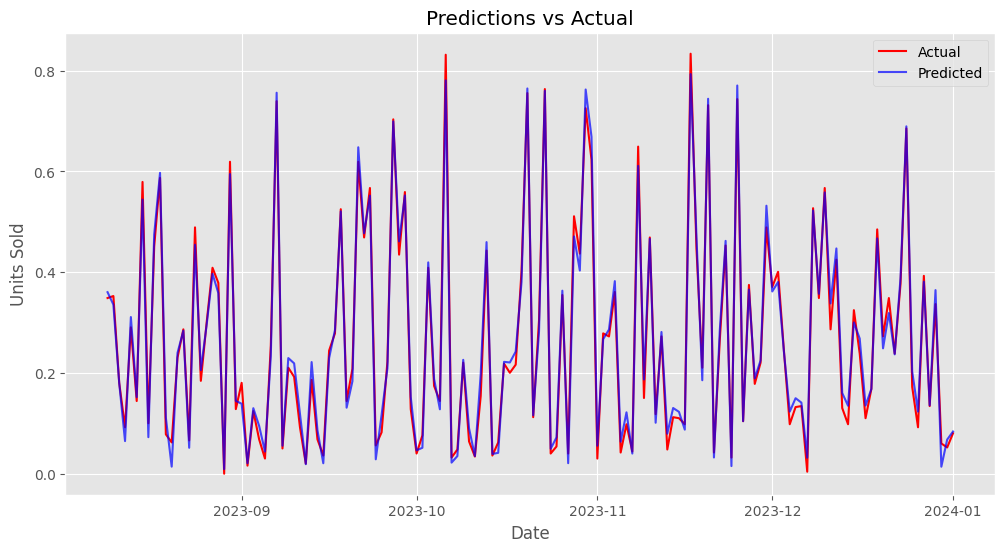

In [34]:
xgb_predictions = xgb_model.predict(test_rf_xgb)

xgb_mae = mean_absolute_error(test["Units Sold"], xgb_predictions)
print(f"XGBoost MAE on Test Set: {xgb_mae}")

plt.figure(figsize=(12, 6))
plt.plot(test.index, test["Units Sold"], label="Actual", color="red")
plt.plot(test.index, xgb_predictions, label="Predicted", color='blue', alpha=0.7)
plt.title("Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

## Data Preparation for Demand Forecasting and Inventory Management

In [35]:
future_rf_xgb = test_rf_xgb.iloc[-1:].copy()

if future_rf_xgb['Competitor Pricing'].dtype == 'object':
    future_rf_xgb['Competitor Pricing'] = future_rf_xgb['Competitor Pricing'].astype(bool).astype(int)

if future_rf_xgb['Seasonality_Winter'].dtype == 'object':
    future_rf_xgb['Seasonality_Winter'] = future_rf_xgb['Seasonality_Winter'].astype(float)

for col in future_rf_xgb.columns:
    if future_rf_xgb[col].dtype == 'bool':
        future_rf_xgb[col] = future_rf_xgb[col].astype(int)

future_rf_xgb = future_rf_xgb[train_rf_xgb.columns]

## Demand Forecasting

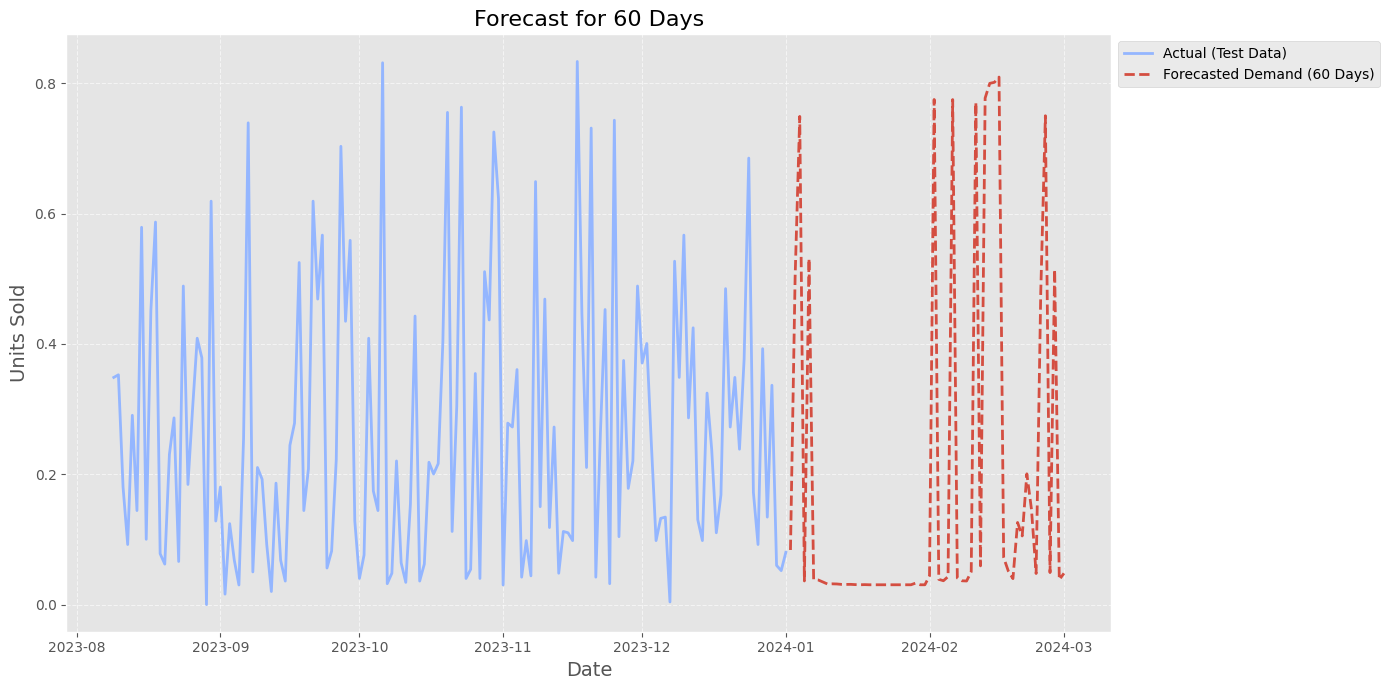

In [36]:
future_periods = 60

future_predictions = []
for _ in range(future_periods):
    pred = xgb_model.predict(future_rf_xgb)
    future_predictions.append(pred[0])
    future_rf_xgb.iloc[0, :-1] = future_rf_xgb.iloc[0, 1:]
    future_rf_xgb.iloc[0, -1] = pred

future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=future_periods, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(test.index, test["Units Sold"], label="Actual (Test Data)", color=custom_palette[2], linewidth=2)
plt.plot(future_dates, future_predictions, label=f"Forecasted Demand ({future_periods} Days)", color=custom_palette[9], linestyle="--", linewidth=2)
plt.title(f"Forecast for {future_periods} Days", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units Sold", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

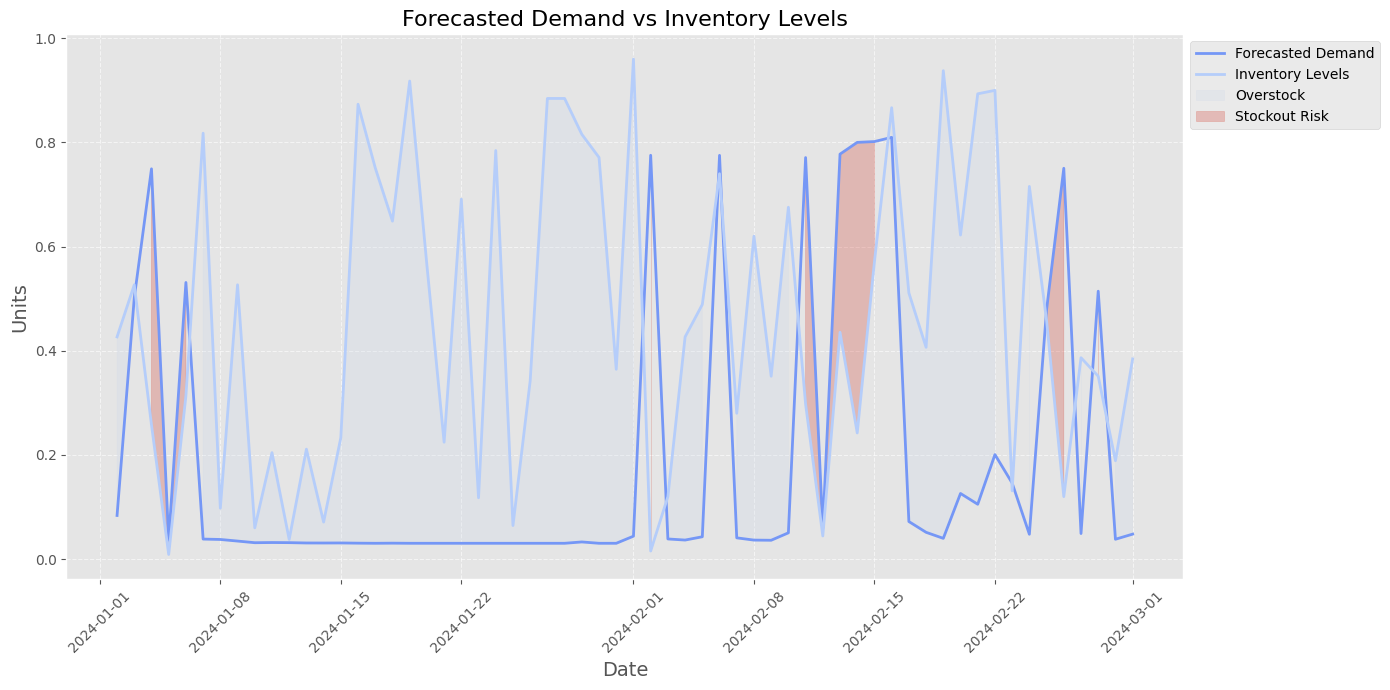

In [37]:
inventory_levels = test["Inventory Level"].values[-future_periods:]

inventory_gap = np.array(inventory_levels) - np.array(future_predictions)

plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, label="Forecasted Demand", color=custom_palette[1], linewidth=2)
plt.plot(future_dates, inventory_levels, label="Inventory Levels", color=custom_palette[3], linewidth=2)
plt.fill_between(future_dates, inventory_levels, future_predictions, 
                 where=(np.array(inventory_levels) > np.array(future_predictions)), 
                 color=custom_palette[4], alpha=0.3, label="Overstock")
plt.fill_between(future_dates, inventory_levels, future_predictions, 
                 where=(np.array(inventory_levels) < np.array(future_predictions)), 
                 color=custom_palette[9], alpha=0.3, label="Stockout Risk")
plt.xticks(rotation=45, fontsize=10)
plt.title("Forecasted Demand vs Inventory Levels", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Safety Stock: 0.45 units


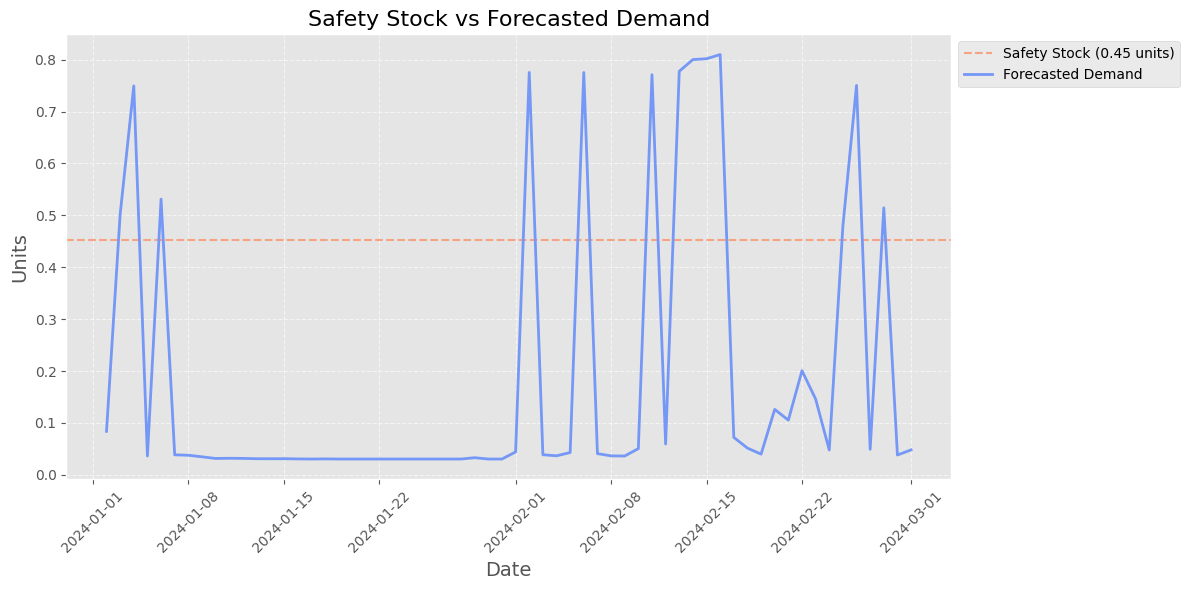

In [38]:
lead_time_days = 3
demand_std = np.std(future_predictions[:lead_time_days])
service_level = 1.65
safety_stock = service_level * demand_std

print(f"Safety Stock: {safety_stock:.2f} units")

plt.figure(figsize=(12, 6))
plt.axhline(y=safety_stock, color=custom_palette[7], linestyle="--", label=f"Safety Stock ({safety_stock:.2f} units)")
plt.plot(future_dates, future_predictions, label="Forecasted Demand", color=custom_palette[1], linewidth=2)
plt.xticks(rotation=45, fontsize=10)
plt.title("Safety Stock vs Forecasted Demand", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Reorder Point: 1.79 units


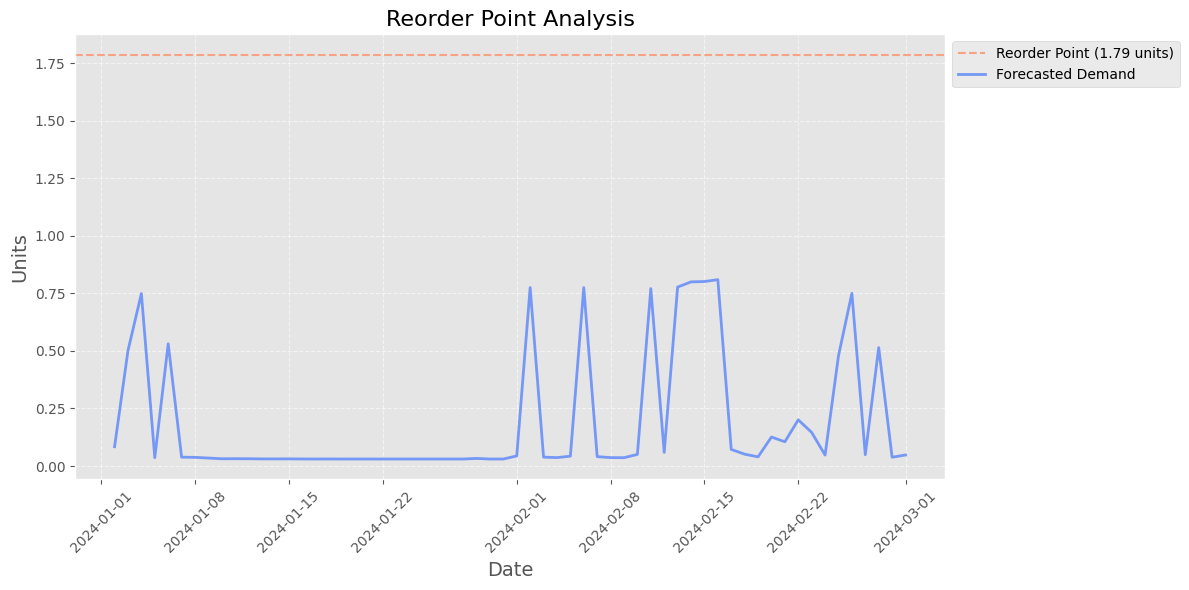

In [39]:
reorder_point = lead_time_days * np.mean(future_predictions[:lead_time_days]) + safety_stock
print(f"Reorder Point: {reorder_point:.2f} units")

plt.figure(figsize=(12, 6))
plt.axhline(y=reorder_point, color=custom_palette[7], linestyle="--", label=f"Reorder Point ({reorder_point:.2f} units)")
plt.plot(future_dates, future_predictions, label="Forecasted Demand", color=custom_palette[1], linewidth=2)
plt.xticks(rotation=45, fontsize=10)
plt.title("Reorder Point Analysis", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [41]:
import joblib
import pickle

# Save Random Forest model
if 'rf_model' in locals():
    joblib.dump(rf_model, 'best_random_forest_model.pkl')
    print("Random Forest model saved as best_random_forest_model.pkl")

# Save XGBoost model
if 'xgb_model' in locals():
    joblib.dump(xgb_model, 'best_xgboost_model.pkl')
    print("XGBoost model saved as best_xgboost_model.pkl")

# Save Prophet model
if 'prophet_model' in locals():
    with open('best_prophet_model.pkl', 'wb') as f:
        pickle.dump(prophet_model, f)
    print("Prophet model saved as best_prophet_model.pkl")

Random Forest model saved as best_random_forest_model.pkl
XGBoost model saved as best_xgboost_model.pkl
Prophet model saved as best_prophet_model.pkl
